# Daily Delhi Climate

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/josumsc/daily-climate-ts/blob/master/src/daily_climate.ipynb)

Project based on the forecasting of the dataset [Daily Climate time series data](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data) available at Kaggle.

Our approach will consider statistical timeseries methods, such as ARIMA or Holt-Winters Smoothing, but also ML techniques as Linear Regression.
Furthermore, we will later on explore recent Deep Learning techniques such as RNNs and LSTMs, as well as the famous Prophet Facebook library.

In [ ]:
!pip install pmdarima
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 9.8 MB 47.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[Download link](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTrain.csv)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pmdarima.utils import plot_acf, plot_pacf
from pmdarima.arima import auto_arima, ADFTest
from pmdarima.metrics import smape

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import lightgbm

import prophet

import tensorflow as tf

from pylab import rcParams
rcParams['figure.figsize'] = (12, 6)

In [ ]:
train_df = pd.read_csv('DailyDelhiClimateTrain.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [ ]:
print(f"Min date: {train_df.date.min()}\nMax date: {train_df.date.max()}") 

Min date: 2013-01-01
Max date: 2017-01-01


In [ ]:
train_df.index = pd.DatetimeIndex(pd.to_datetime(train_df['date']), freq='D')
train_df.drop('date', axis=1, inplace=True)

In [ ]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Checking the data distributions of the independent features

First, we need to check the distribution of the main variables so we can infer if there was a measurement problem during a particular period of time. Furthermore, this will allow us to detect patterns and outliers before dealing with deeper analysis.

### Mean Pressure

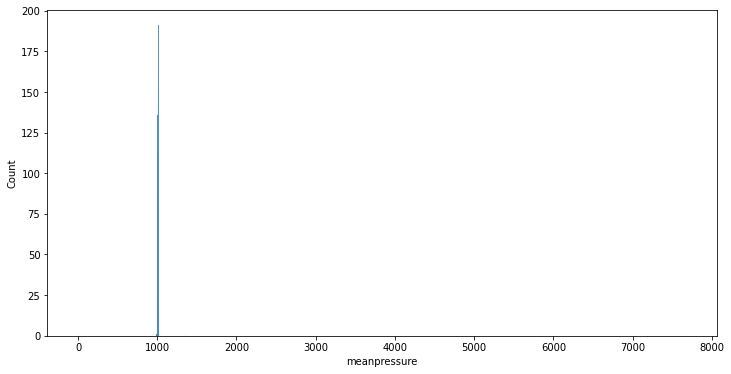

In [ ]:
sns.histplot(train_df['meanpressure'],)
plt.show()

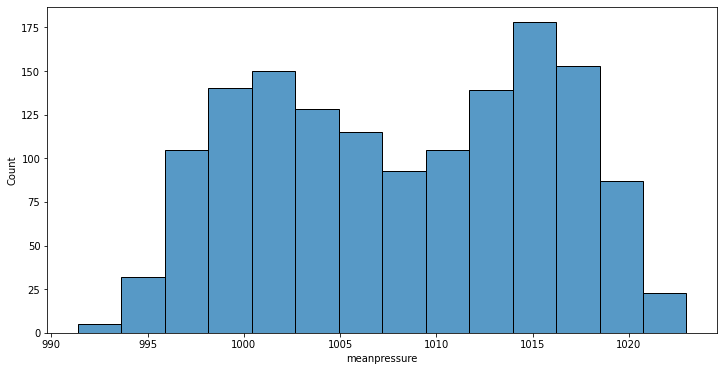

In [ ]:
# https://www.theweatherprediction.com/habyhints3/909/
# https://barometricpressure.app/new-delhi
f = (train_df['meanpressure'] < 1050) & (train_df['meanpressure'] > 950)
sns.histplot(
    train_df[f]['meanpressure'],
)
plt.show()

In [ ]:
train_df[train_df['meanpressure'] < 950]

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-06-09,35.733333,43.733333,9.260000,938.066667
2016-07-24,31.437500,72.250000,2.431250,946.312500
2016-08-02,30.687500,72.125000,6.375000,310.437500
2016-08-14,28.933333,83.700000,6.370000,633.900000
2016-08-16,31.333333,66.416667,14.666667,-3.041667
2016-11-28,22.454545,37.318182,9.185714,12.045455


In [ ]:
train_df[train_df['meanpressure'] > 1050]

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-03-28,25.933333,52.800000,6.546667,7679.333333
2016-09-24,31.240000,66.480000,5.496154,1352.615385
2016-11-17,21.730769,51.730769,11.550000,1350.296296


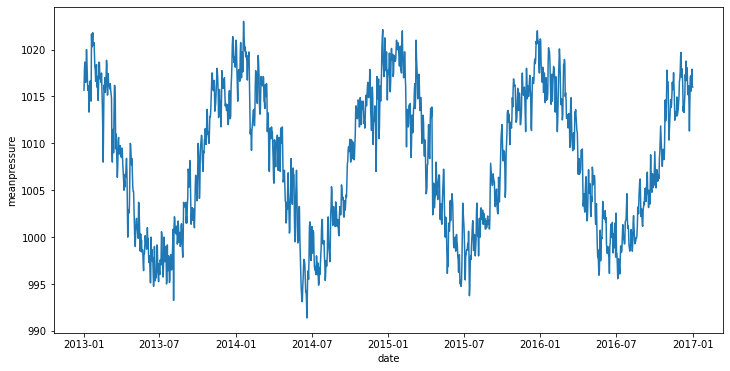

In [ ]:
sns.lineplot(
    x=train_df[f].index,
    y=train_df[f]['meanpressure']
)
plt.show()

We see that the `meanpressure` column has several values that are not in the acceptable range. By consulting online, we see that the normal range for atmospheric pressure is between 950 and 1050 hPa. If we were to consider this column in our forecast, we should impute the values outside of that range by the rolling mean of the previous $K$ periods, which in this case could be 7.

Regarding the distribution, we see that there is a bimodal distribution that approaches normality, and the data is cyclically distributed on the time.

### Wind Speed

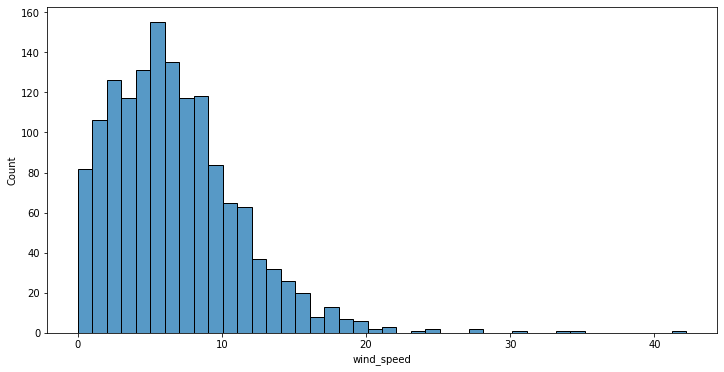

In [ ]:
sns.histplot(train_df['wind_speed'],)
plt.show()

In [ ]:
def detect_outliers_iqr(data):
  p25 = np.percentile(data, 25)
  p75 = np.percentile(data, 75)
  iqr = p75 - p25
  lower_bound, upper_bound = (p25 - 1.5 * iqr, p75 + 1.5 * iqr)
  f = (data < lower_bound) | (data > upper_bound)
  return data[f], data[~f] 

In [ ]:
outliers, cleaned_series = detect_outliers_iqr(train_df['wind_speed'])
train_df.loc[outliers.index]

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-03-01,17.333333,49.333333,24.066667,1016.333333
2013-08-24,32.000000,71.250000,18.525000,1000.333333
2013-09-09,31.000000,57.500000,42.220000,1007.000000
2013-11-08,18.000000,82.200000,19.912500,1015.625000
2013-12-25,13.666667,63.166667,34.487500,1020.625000
2014-01-06,11.428571,86.285714,27.337500,1017.625000
2014-01-07,12.142857,72.285714,20.600000,1017.750000
2014-05-23,34.625000,32.750000,19.450000,1000.000000
2014-06-12,32.875000,39.250000,24.325000,997.000000


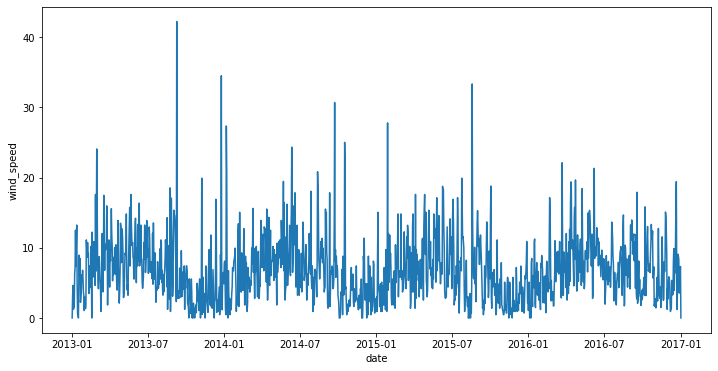

In [ ]:
sns.lineplot(
    x=train_df.index,
    y=train_df['wind_speed']
)
plt.show()

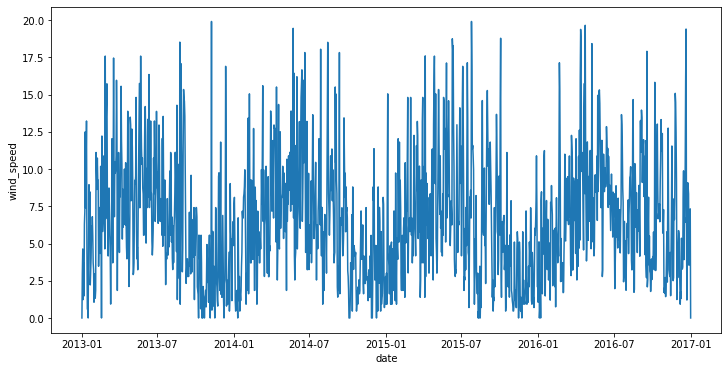

In [ ]:
sns.lineplot(
    x=train_df[train_df['wind_speed'] < 20].index,
    y=train_df[train_df['wind_speed'] < 20]['wind_speed']
)
plt.show()

Regaring the `wind_speed`, we still observe outliers in the data. We see that using the interquartile range, we can detect the outliers and impute them by the rolling mean of the previous $K$ periods, which in this case could be 7 again.

We still see observe a cyclical behavior in the data, and the distribution is skewed to the right thanks to extreme values on that part.

### Humidity

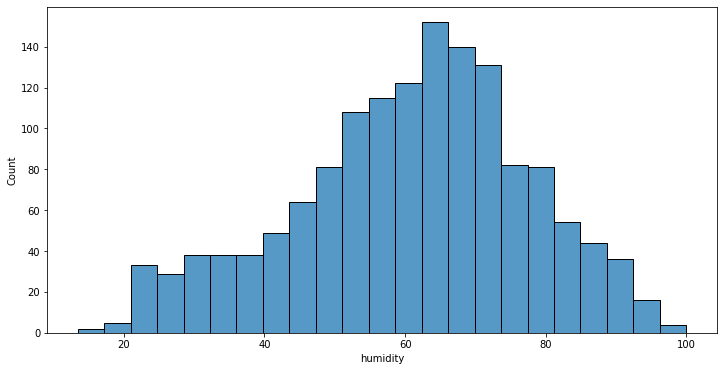

In [ ]:
sns.histplot(train_df['humidity'],)
plt.show()

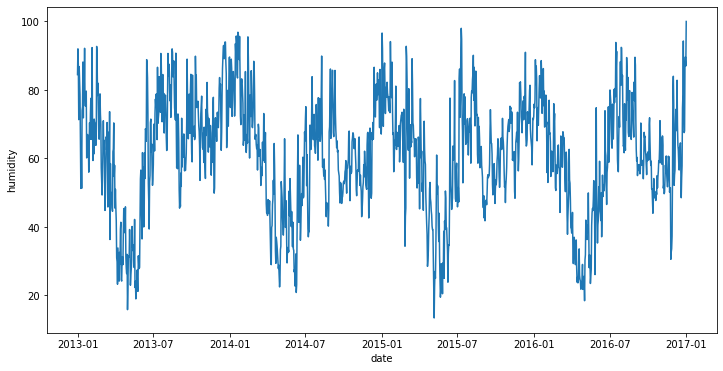

In [ ]:
sns.lineplot(
    x=train_df.index,
    y=train_df['humidity']
)
plt.show()

This time, we don't observe any extreme values, while still seen the cyclical behavior in the data. The distribution is more normally distributed than the previous variables, although we still observe a certain skewness to the left.

## Description of the target variable

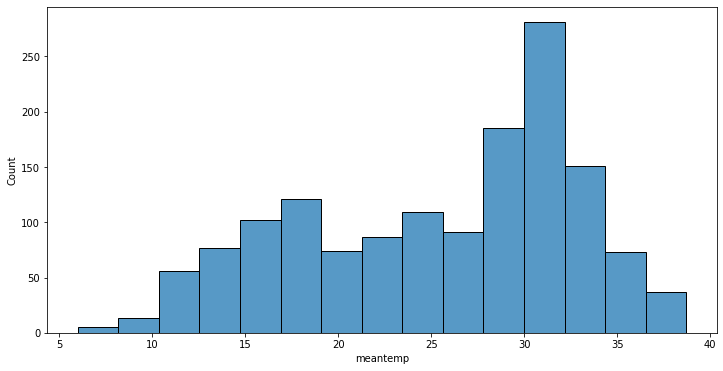

In [ ]:
sns.histplot(train_df['meantemp'],)
plt.show()

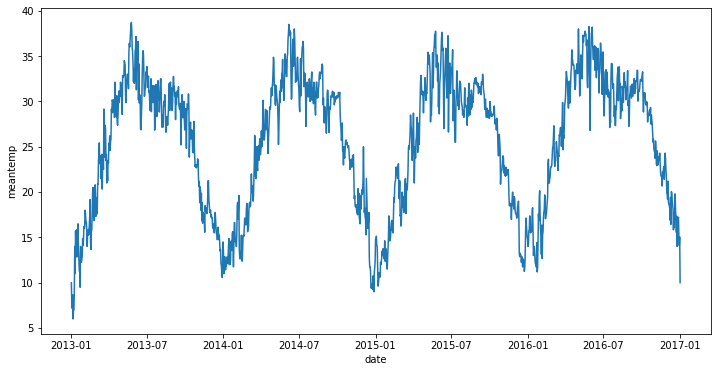

In [ ]:
sns.lineplot(
    x=train_df.index,
    y=train_df['meantemp']
)
plt.show()

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


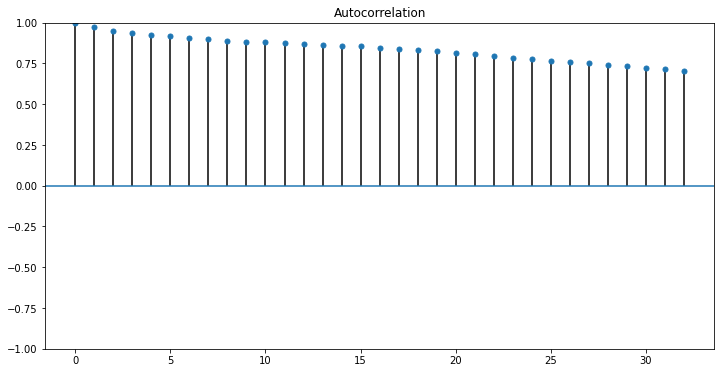

In [ ]:
plot_acf(train_df['meantemp'])

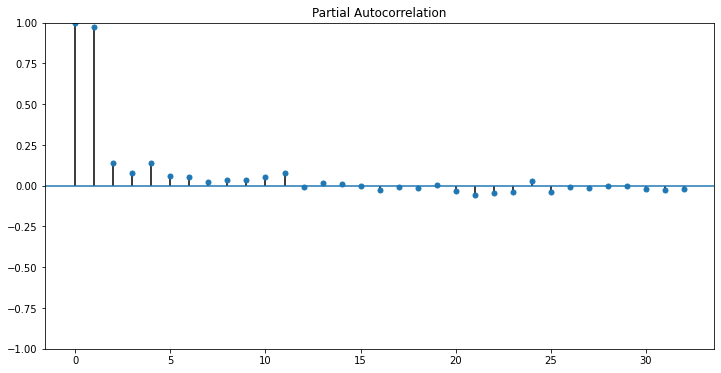

In [ ]:
plot_pacf(train_df['meantemp'])

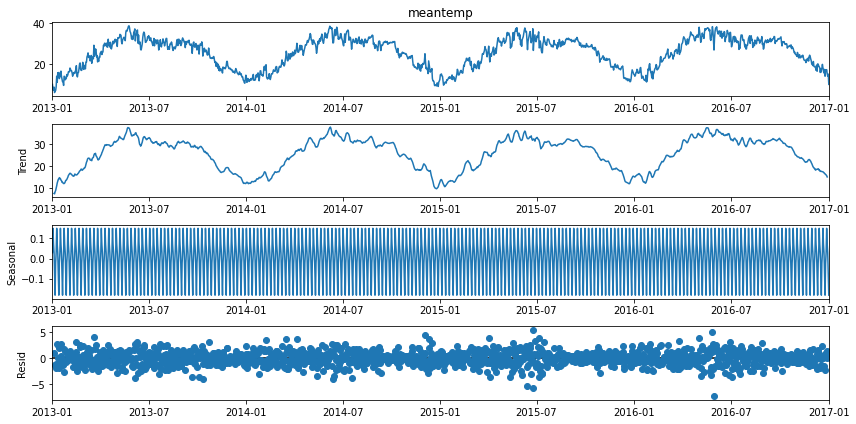

In [ ]:
result = seasonal_decompose(train_df['meantemp'])
_ = result.plot()

In [ ]:
adf_test = ADFTest()
adf_test.should_diff(train_df['meantemp'])

(0.6407142787617243, True)

While taking a look at our target variable, we observe a clear seasonality which seems to be yearly. We also see that the main lag to be considered on the autocorrelation is the lag 1, which is the previous day.

Finally, we see that the data is not stationary so we could apply a transformation to make it stationary or let models as ARIMA to deal with it by its own means by integrating the data, for instance.

## Modelling

In [ ]:
val_periods = 180
training_df = train_df.iloc[:train_df.shape[0]-val_periods, :]
val_df = train_df.iloc[-val_periods:, :]

In [ ]:
def evaluate_model(y_true, y_hat):
  pred_smape = smape(y_true, y_hat)
  pred_mae = mean_absolute_error(y_true, y_hat)
  pred_mse = mean_squared_error(y_true, y_hat)
  print(f"SMAPE: {pred_smape}\nMAE: {pred_mae}\nMSE: {pred_mse}")
  return pred_smape, pred_mae, pred_mse

### ARIMA

In [ ]:
arima_model = auto_arima(
    training_df['meantemp'], start_d=1, max_d=12, max_q=12,
    seasonal=True, m=12, max_D=12, max_Q=12, stationary=False,
    n_jobs=-1, verbose=True
)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


In [ ]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1282
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2444.060
Date:                            Sun, 18 Sep 2022   AIC                           4898.121
Time:                                    17:34:48   BIC                           4923.898
Sample:                                01-01-2013   HQIC                          4907.800
                                     - 07-05-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5999      0.047     12.724      0.000       0.507       0.692
ma.L1         -0.8240      0.037   

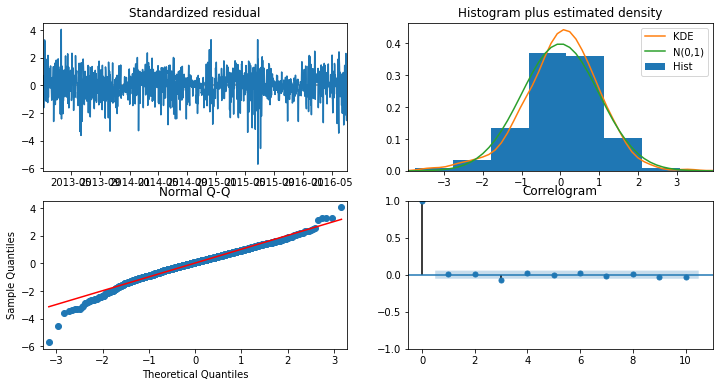

In [ ]:
arima_model.plot_diagnostics()
plt.show()

In [ ]:
arima_preds = arima_model.predict(val_periods)
arima_smape, arima_mae, arima_mse = evaluate_model(val_df['meantemp'], arima_preds)

SMAPE: 21.358837525462153
MAE: 5.740656920902892
MSE: 62.37144965226854


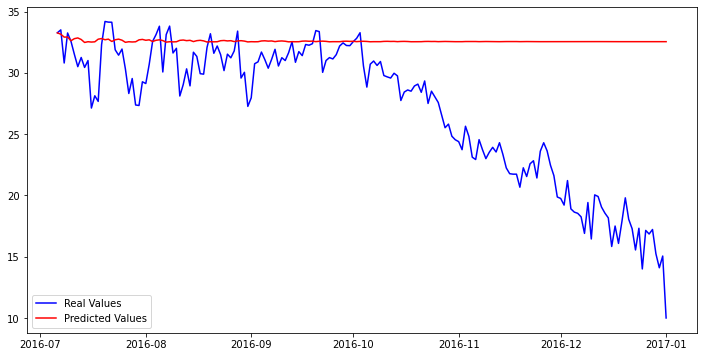

In [ ]:
plt.plot(val_df['meantemp'], color='blue', label='Real Values')
plt.plot(val_df.index, arima_preds, color='red', label='Predicted Values')
plt.legend()
plt.show()

Even though the residuals of the model seem to be normally distributed and the qqplot seems OK, by observing our predictions we see that the model does not manage to capture the particularities of our data, and the mentioned predictions are basically ignoring the time and converging towards a value around 33 degrees.

### Holt-Winters

In [ ]:
hw_trend = 'additive'
hw_seasonal = 'additive'

hw_model = ExponentialSmoothing(
    training_df['meantemp'], trend=hw_trend, seasonal=hw_seasonal,
    seasonal_periods=12,
)
hw_model = hw_model.fit()
hw_preds = hw_model.forecast(val_periods)

In [ ]:
hw_smape, hw_mae, hw_mse = evaluate_model(val_df['meantemp'], hw_preds)

SMAPE: 26.399003698784338
MAE: 7.526914747052522
MSE: 96.98586675336301


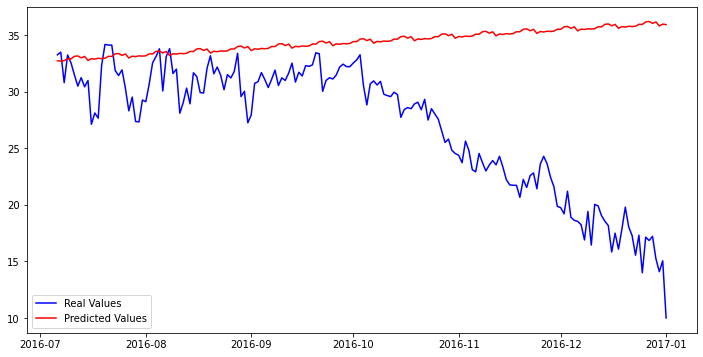

In [ ]:
plt.plot(val_df['meantemp'], color='blue', label='Real Values')
plt.plot(hw_preds, color='red', label='Predicted Values')
plt.legend()
plt.show()

Using the Holt-Winters approach, we observe a similar behavior as with the ARIMA model. In this case, the model seems to be able to capture the upwards trend of the temperature, but it is not able to capture the seasonality of the data as it does not decrease the temperature during the winter months.

### Prophet

In [ ]:
m = prophet.Prophet()
m.fit(training_df['meantemp'].reset_index().rename({'date': 'ds', 'meantemp': 'y'}, axis=1))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpabjk_ctk/h7wbhcjd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpabjk_ctk/oh41emfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67815', 'data', 'file=/tmp/tmpabjk_ctk/h7wbhcjd.json', 'init=/tmp/tmpabjk_ctk/oh41emfo.json', 'output', 'file=/tmp/tmp3f1veb7y/prophet_model-20220918173451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=val_periods, include_history=True)
prophet_preds = m.predict(future)['yhat']

In [ ]:
prophet_smape, prophet_mae, prophet_mse = evaluate_model(val_df['meantemp'], prophet_preds.iloc[-val_periods:])

SMAPE: 6.415100506526297
MAE: 1.729287962314801
MSE: 5.058145760514788


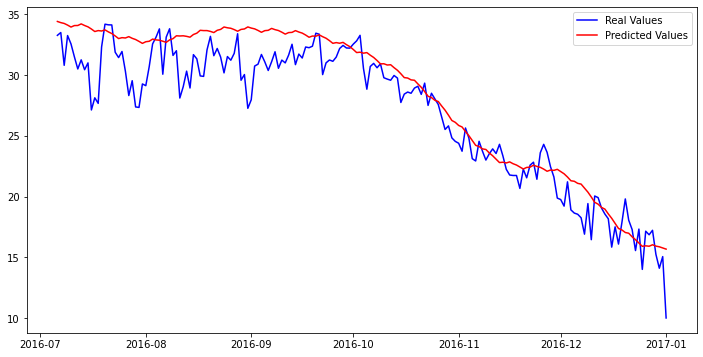

In [ ]:
plt.plot(val_df['meantemp'], color='blue', label='Real Values')
plt.plot(val_df.index, prophet_preds.iloc[-val_periods:], color='red', label='Predicted Values')
plt.legend()
plt.show()

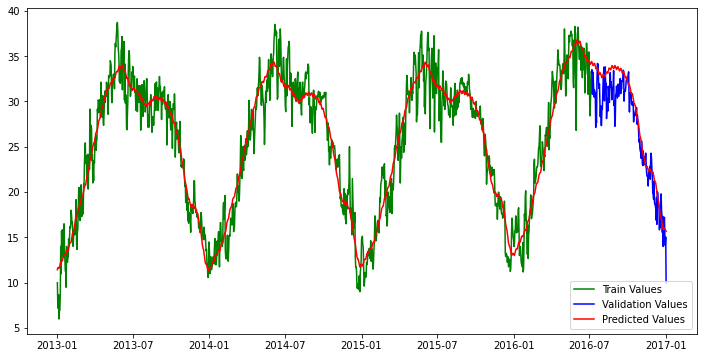

In [ ]:
plt.plot(training_df['meantemp'], color='green', label='Train Values')
plt.plot(val_df['meantemp'], color='blue', label='Validation Values')
plt.plot(pd.date_range(start=training_df.index.min(), end=val_df.index.max()), prophet_preds, color='red', label='Predicted Values')
plt.legend()
plt.show()

Finally we reached a model that was able to capture both the trend and the seasonality of our model, generating a set of predictions that are both accurate on the train data and reasonable on the validation data. Even though the model seems to make higher predictions than it should, we could use the confidence intervals and the rest of the data provided by the Prophet model to compensate for that on a production environment given that known feature of the model.

## Linear Regression

By extracting some features from the date of the data, we can face the problem as a regular supervised task. We can use the extracted features as independent variables and the temperature as the target variable. 

We can start this approach by using a simple linear regression model to predict the temperature and thus see if this methodology makes sense for this data before applying more advanced models.

In [ ]:
def extract_date_features(original_df):
  df = original_df.copy()
  df['yearday'] = df.index.day_of_year
  df['yearday_sin'] = np.sin(2 * np.pi * df['yearday']/df['yearday'].max())
  df['yearday_cos'] = np.cos(2 * np.pi * df['yearday']/df['yearday'].max())
  df['month'] = df.index.month
  df['monthday'] = df.index.day
  df['monthday_sin'] = np.sin(2 * np.pi * df['monthday']/df['monthday'].max())
  df['monthday_cos'] = np.cos(2 * np.pi * df['monthday']/df['monthday'].max())
  df['weekday'] = df.index.weekday
  df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/df['weekday'].max())
  df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/df['weekday'].max())
  return df

In [ ]:
training_df_featurized = extract_date_features(training_df)

In [ ]:
val_df_featurized = extract_date_features(val_df)

In [ ]:
X = training_df_featurized[[
  'yearday_sin', 'yearday_cos', 'monthday_sin', 'monthday_cos', 'weekday_sin', 'weekday_cos',
]]
y = training_df_featurized.meantemp

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_preds = linear_model.predict(
  val_df_featurized[[
  'yearday_sin', 'yearday_cos', 'monthday_sin', 'monthday_cos', 'weekday_sin', 'weekday_cos',
]]
)

In [ ]:
linear_smape, linear_mae, linear_mse = evaluate_model(val_df['meantemp'], linear_preds)

SMAPE: 13.821344020810672
MAE: 3.4524130098603676
MSE: 16.136692137075062


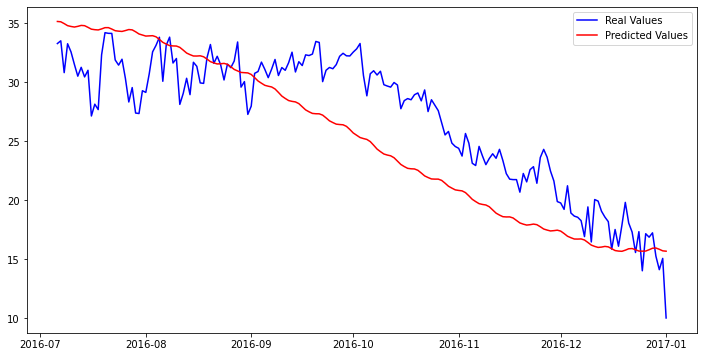

In [ ]:
plt.plot(val_df['meantemp'], color='blue', label='Real Values')
plt.plot(val_df.index, linear_preds, color='red', label='Predicted Values')
plt.legend()
plt.show()

Even though our model was quite simple, we still managed to get better scores than using more complicated methods as ARIMA and Holt-Winters. We still did not manage to outperform the Prophet model, but we can see that our approach is validated and can now start applying state-of-the-art models to this problem, as Gradient Boosting or Neural Networks.

### LightGBM

In [ ]:
light_model = lightgbm.LGBMRegressor()
light_model.fit(X, y)
light_preds = light_model.predict(
  val_df_featurized[[
  'yearday_sin', 'yearday_cos', 'monthday_sin', 'monthday_cos', 'weekday_sin', 'weekday_cos',
]]
)

In [ ]:
light_smape, light_mae, light_mse = evaluate_model(val_df['meantemp'], light_preds)

SMAPE: 10.014558122288971
MAE: 2.2827806056459874
MSE: 7.238674634444717


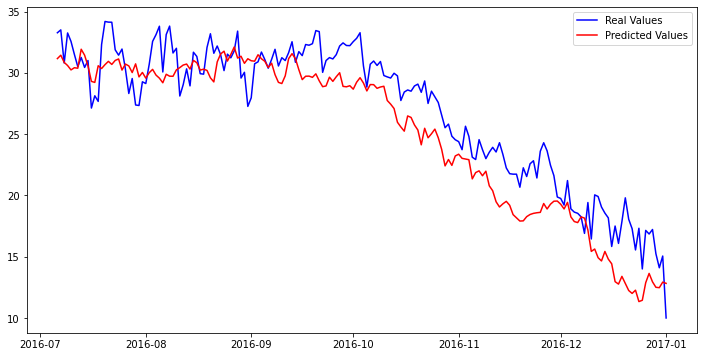

In [ ]:
plt.plot(val_df['meantemp'], color='blue', label='Real Values')
plt.plot(val_df.index, light_preds, color='red', label='Predicted Values')
plt.legend()
plt.show()

As it was expected, by applying a more advanced algorithm we managed to get better results than the simple linear regression model. Our Prophet model is still king, but we can see that we are getting closer to it and that we can tackle time-series problems using base supervised approaches without losing much accuracy.

### Univariate Seq2Seq

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):  
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    forecast = model.predict(dataset)
    
    return forecast

We could run the following function to obtain the best learning rate for our model:

In [ ]:
def plot_lr_curves(model, optimizer, criterion, start_lr=1e-6, epochs=50):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: start_lr * 10**(epoch / 10))
    model.compile(loss=criterion, optimizer=optimizer)
    history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule])

    lrs = start_lr * (10 ** (np.arange(epochs) / 10))
    plt.grid(True)
    plt.semilogx(lrs, history.history["loss"])
    plt.tick_params('both', length=10, width=1, which='both')
    plt.show()

In [ ]:
window_size = 45
batch_size = 64
shuffle_buffer_size = 1000

hidden_dim_rnn = 64
hidden_dim_fc = 50
dropout = 0.4

criterion = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 100

In [ ]:
train_set = windowed_dataset(training_df['meantemp'], window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(val_df['meantemp'], window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation=tf.nn.relu,
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.LSTM(hidden_dim_rnn, return_sequences=True, dropout=dropout, recurrent_dropout=dropout),
  tf.keras.layers.LSTM(hidden_dim_rnn, dropout=dropout, recurrent_dropout=dropout),
  tf.keras.layers.Dense(hidden_dim_fc, activation=tf.nn.relu),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(hidden_dim_fc, activation=tf.nn.relu),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(1),
])

init_weights = model.get_weights()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 45, 64)            256       
                                                                 
 dropout (Dropout)           (None, 45, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 45, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2

In [ ]:
# plot_lr_curves(model, keras.optimizers.Adam(), criterion)

In [ ]:
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae', 'mse'])

In [ ]:
model.set_weights(init_weights)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_loss')
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[early_stopping, reduce_lr_on_plateau])

Epoch 1/100
20/20 [==============================] - 29s 522ms/step - loss: 21.6270 - mae: 22.1270 - mse: 554.5500 - val_loss: 13.2055 - val_mae: 13.7055 - val_mse: 220.2089 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 9s 407ms/step - loss: 9.3933 - mae: 9.8840 - mse: 143.7351 - val_loss: 4.6543 - val_mae: 5.1321 - val_mse: 41.0951 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 8s 411ms/step - loss: 7.5083 - mae: 7.9943 - mse: 97.5977 - val_loss: 4.7828 - val_mae: 5.2613 - val_mse: 35.9109 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 8s 402ms/step - loss: 7.4818 - mae: 7.9685 - mse: 92.8445 - val_loss: 4.5946 - val_mae: 5.0830 - val_mse: 32.7884 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 8s 409ms/step - loss: 7.1487 - mae: 7.6327 - mse: 86.2921 - val_loss: 4.4380 - val_mae: 4.9298 - val_mse: 30.8204 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 8s 408ms/step - loss: 7.0348 - mae: 7.5

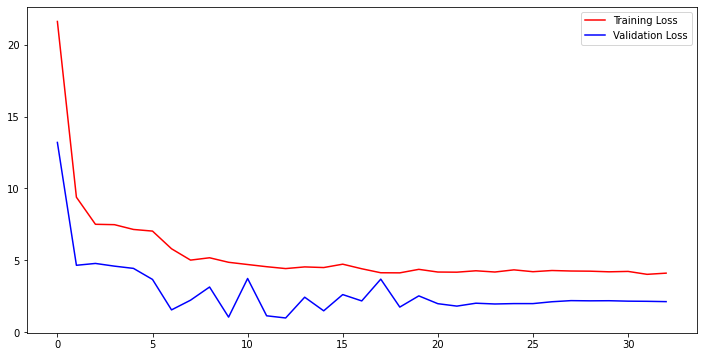

In [ ]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], color='red', label='Training Loss')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], color='blue', label='Validation Loss')
plt.legend()
plt.show()

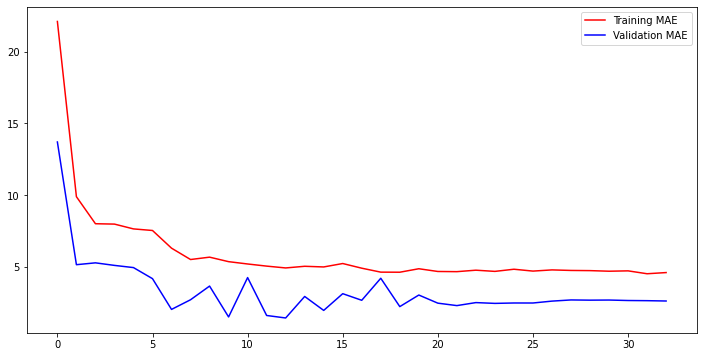

In [ ]:
plt.plot(history.history['mae'], color='red', label='Training MAE')
plt.plot(history.history['val_mae'], color='blue', label='Validation MAE')
plt.legend()
plt.show()

In [ ]:
forecast_series = train_df.iloc[val_periods-window_size:-1, :]['meantemp']
rnn_preds = model_forecast(model, forecast_series, window_size, batch_size).squeeze()

In [ ]:
rnn_smape, rnn_mae, rnn_mse = evaluate_model(val_df['meantemp'], rnn_preds[-val_periods:])

SMAPE: 5.749113391916605
MAE: 1.4825394044022586
MSE: 3.3709046510292215


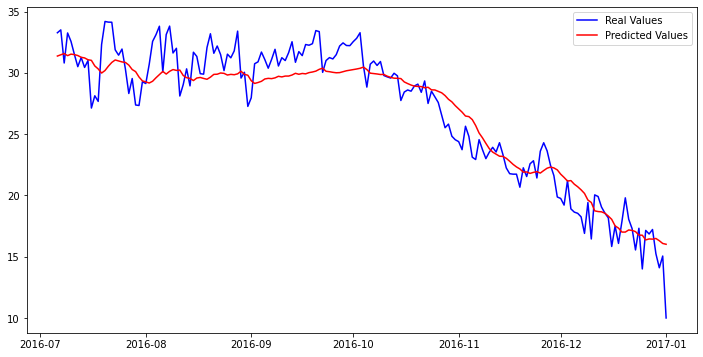

In [ ]:
plt.plot(val_df['meantemp'], color='blue', label='Real Values')
plt.plot(val_df.index, rnn_preds[-val_periods:], color='red', label='Predicted Values')
plt.legend()
plt.show()

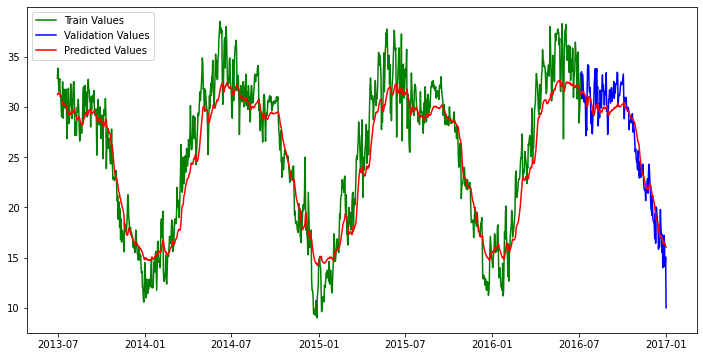

In [ ]:
windowed_training_df = training_df.iloc[len(training_df) + len(val_df) - len(rnn_preds):, :]
plt.plot(windowed_training_df['meantemp'], color='green', label='Train Values')
plt.plot(val_df['meantemp'], color='blue', label='Validation Values')
plt.plot(pd.date_range(start=windowed_training_df.index.min(), end=val_df.index.max()), rnn_preds, color='red', label='Predicted Values')
plt.legend()
plt.show()

On the accuracy front, this model was our best bet, showing great results on the whole training and validation sets. If we were on a Kaggle competition, we would present this model as our final candidate despite of its lack of interpretability and their longer training times.

## Final model and predictions

Even though LightGBM and Seq2Seq models were able to capture the features of the data and generate great predictions, they take longer to train than the Prophet model and their API provide less time-series functionalities such as intervals or seasonality. For that reason, we will use the Prophet model as our final model.

In [ ]:
# first day is already included in train
test_df = pd.read_csv('DailyDelhiClimateTest.csv').iloc[1:,:]
test_df.date = pd.to_datetime(test_df.date)
test_df_periods = (test_df.date.max() - test_df.date.min()).days

In [ ]:
m = prophet.Prophet()
m.fit(train_df['meantemp'].reset_index().rename({'date': 'ds', 'meantemp': 'y'}, axis=1))
future = m.make_future_dataframe(periods=test_df_periods, include_history=True)
prophet_preds = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpabjk_ctk/vqj31_d1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpabjk_ctk/694nakpr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79544', 'data', 'file=/tmp/tmpabjk_ctk/vqj31_d1.json', 'init=/tmp/tmpabjk_ctk/694nakpr.json', 'output', 'file=/tmp/tmptjyit3nf/prophet_model-20220918175617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
final_df = prophet_preds.merge(test_df, left_on='ds', right_on='date')

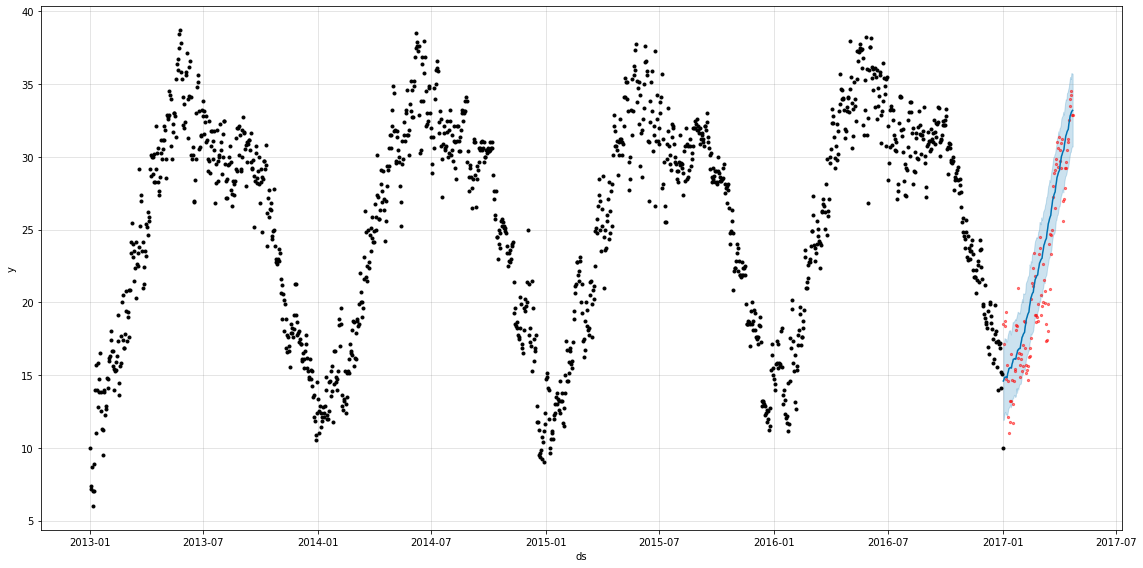

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
m.plot(final_df, ax=ax)
ax.scatter(final_df.date, final_df.meantemp, color='red', s=5, alpha=.5)
plt.show()

In [ ]:
rnn_smape, rnn_mae, rnn_mse = evaluate_model(final_df['meantemp'], final_df['yhat'])

SMAPE: 11.065794126425297
MAE: 2.2135975860549753
MSE: 7.286646734460831


Observing the results of our model, we see that the predictions are highly accurate, with a MAE of 2.2 degrees. Plotting the forecast, we see that most of the points fall within the confidence interval, which is a good sign that the model is not overfitting.

As a conclusion, we could say that we managed to tackle the problem of forecasting the temperature of a city using a time-series dataset. We started by using simple statistical methods such as ARIMA and Holt-Winters, but we also used more advanced methods such as Prophet and Deep Learning models such as Seq2Seq. We also used a simple linear regression model and a more advanced tree-based model as LightGBM to show that we can tackle time-series problems using base supervised approaches without losing much accuracy.